In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import  accuracy_score

%matplotlib inline 

## Введение (Introduction)
Данный блокнот является дополнительным материалом к демонстрации примеров классификации спектров излучения источников искусственного и естественного света представленной публикации на портале Habrahabr –   
  
Внимание! Изложенные ниже методы и данные на основании, которых проводится классификация, собраны на основании материалов, размещенных пользователями в общем доступе на портале https://spectralworkbench.org/  и не предполагают научной достоверности.
Учитывая возможные ошибки вызванные техническими и «человеческими» факторами рекомендуется применение набора данных исключительно в демонстрационных целях. 


Materials may contain errors, not recommended for serious research.
Spectrum source https://spectralworkbench.org/  
P.S. English text from google translate :)

# Описание данных (Data description)
Набор данных состоит из тестовой и обучающей выборки, описывающей спектры источников света.  
Спектральные характеристики разбиты на 301 признаков где значение признака соответствует длине волны в спектре.    
Значение признака – условная мощность излучения.   
Поле label содержит метку источника света:  
0-	Светодиодная лампа (белый свет от WW/CW/NW/RGB светодиодов или их комбинации);  
1-	Люминесцентная лампа (компактная или трубчатая);  
2-	Дневной свет (солнце, небо, или их комбинация);  
train.csv – обучающая выборка;  
train.csv – обучающая выборка;  
train_names csv , test_names.csv– имена источников спектра для train и test соответственно.
Просмотреть исходный спектр можно по адресу :
https://spectralworkbench.org/spectrums/XXXX  
где: XXXX- имя спектра в файле.
Например: https://spectralworkbench.org/spectrums/9740


The data set consists of a test and training sample that describes the spectrum of light sources.
Spectral characteristics are divided into 301 features where the value of the characteristic corresponds to the wavelength in the spectrum.
The value of the characteristic is the emission power.  
The label field contains the light source label:  
0- LED lamp (white light from WW / CW / NW / RGB LEDs or their combination);  
1- Fluorescent lamp (compact or tube);  
2- Daylight (sun, sky, or or their combination);  
train.csv - training sample, train.csv - training sample;  
train names csv, test_names.csv - filenames of the spectrum sources for train and test, respectively.
View the original spectrum can be found at:
https://spectralworkbench.org/spectrums/XXXX  
where: XXXX is the name of the spectrum in the file.
For example: https://spectralworkbench.org/spectrums/9740


train shape (90, 302), test shape (33, 302)]


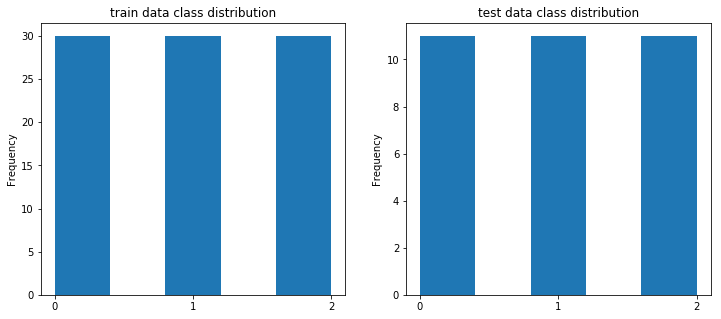

In [2]:
#reading data
train_df=pd.read_csv('train.csv',index_col=0)
test_df=pd.read_csv('test.csv',index_col=0)
print('train shape {0}, test shape {1}]'. format(train_df.shape, test_df.shape))


#draw classdistributions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
train_df.label.plot.hist(ax=axes[0],title='train data class distribution', bins=5,xticks=np.unique(train_df.label.values))
test_df.label.plot.hist(ax=axes[1],title='test data class distribution',bins=5,xticks=np.unique(test_df.label.values))

#divide the data and labels
X_train=np.array(train_df.iloc[:,:-1])
X_test=np.array(test_df.iloc[:,:-1])
y_train=np.array(train_df['label'])
y_test=np.array(test_df['label'])

## Random Forest

Для начала подберем параметры Random Forest вручную   
  
Let's select parameters manually

In [3]:
rfc = RandomForestClassifier(n_estimators=30, max_depth=5, random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)
pred_rfc=rfc.predict(X_test)
print("results (predict, real): \n",list(zip(pred_rfc,y_test)))
print("accuracy score= {0}".format(rfc.score(X_test,y_test)))


results (predict, real): 
 [(2, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (2, 0), (2, 0), (2, 0), (1, 1), (1, 1), (1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
accuracy score= 0.8181818181818182


Подберем наилучшие параметры с помощью решетчатого поиска и кросс-валидации GridSearchCV. Параметры взяты из расчета наглядности демонстрации и быстроты расчета и могут не обеспечивать самый лучший результат.

We will select the best parameters using GridSearchCV. The parameters are chosen based on computing speed and clarity and may not provide the best result.

In [4]:
%%time
param_grid = {'n_estimators':[10, 20, 30, 40, 50],  'max_depth':[4,5,6,7,8]}

grid_search_rfc = GridSearchCV(RandomForestClassifier(random_state=42,n_jobs=-1), param_grid, cv=7)

grid_search_rfc.fit(X_train, y_train)

print(grid_search_rfc.best_params_,grid_search_rfc.best_score_)

print("best accuracy on cv: {:.2f}".format(grid_search_rfc.best_score_))
print("accuracy on test data: {:.5f}".format(grid_search_rfc.score(X_test, y_test)))
print("best params: {}".format(grid_search_rfc.best_params_))
print("results (predict, real): \n",list(zip(grid_search_rfc.best_estimator_.predict(X_test),y_test)))


{'max_depth': 6, 'n_estimators': 30} 0.766666666667
best accuracy on cv: 0.77
accuracy on test data: 0.87879
best params: {'max_depth': 6, 'n_estimators': 30}
results (predict, real): 
 [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (2, 0), (2, 0), (2, 0), (1, 1), (1, 1), (1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
Wall time: 1min 6s


In [5]:
rfc = RandomForestClassifier(n_estimators=30, max_depth=6, random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)
pred=rfc.predict(X_test)
print("results (predict, real): \n",list(zip(pred,y_test)))
print("accuracy score= {0}".format(rfc.score(X_test,y_test)))


results (predict, real): 
 [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (2, 0), (2, 0), (2, 0), (1, 1), (1, 1), (1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
accuracy score= 0.8787878787878788


В данном случае мы оптимизировали только 2 параметра и оказалось, что изменение max_depth на 1 дает прирост точности предсказаний. При этом заметьте, что в данном случае увеличение числа решающих деревьев не увеличивает существенно качество.
Необходимо отметить, что много зависит от параметров кросс-валидации GridSearchCV и словаря param_grid, при других параметрах, есть возможность получить результат хуже чем был подобран без использования GridSearchCV  
  

In the demo example, changing 1 of the two parameters gives an increase accuracy. While an increase in n_Estimators is not required.
The result also depends on the GridSearchCV and param_grid settings

## LogisticRegression

В качестве альтернативы рассмотрим другой алгоритм, для начала выберем параметры вручную
Для малых наборов данных советуют взять выбрать алгоритм ‘liblinear’ (по умолчанию) значит его и оставим.

As an alternative, consider another algorithm. select the parameters manually. Choosing the solver by default is good for small data


In [6]:
logreg = LogisticRegression(penalty='l2',random_state=42,  C=1, n_jobs=-1)
logreg.fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("results (predict, real): \n",list(zip(pred_logreg,y_test)))
print("accuracy score= {0}".format(logreg.score(X_test,y_test)))

results (predict, real): 
 [(0, 0), (0, 0), (0, 0), (2, 0), (0, 0), (0, 0), (0, 0), (2, 0), (0, 0), (0, 0), (2, 0), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (2, 2), (2, 2), (2, 2), (0, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
accuracy score= 0.7878787878787878



Также, как и в прошлом случае попробуем GridSearchCV

Also try a GridSearchCV


In [7]:
%%time
param_grid = {'C':[0.00020, 0.0020, 0.020, 0.20, 1.2],  'penalty':['l1','l2']}

grid_search_logr = GridSearchCV(LogisticRegression(random_state=42,n_jobs=-1), param_grid, cv=3)

grid_search_logr.fit(X_train, y_train)

print("best accuracy on cv: {:.2f}".format(grid_search_logr.best_score_))
print("accuracy on test data: {:.5f}".format(grid_search_logr.score(X_test, y_test)))
print("best params: {}".format(grid_search_logr.best_params_))
print("results (predict, real): \n",list(zip(grid_search_logr.best_estimator_.predict(X_test),y_test)))

best accuracy on cv: 0.79
accuracy on test data: 0.81818
best params: {'C': 0.02, 'penalty': 'l1'}
results (predict, real): 
 [(0, 0), (0, 0), (0, 0), (2, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (2, 0), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (2, 2), (2, 2), (2, 2), (0, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
Wall time: 718 ms


Оптимизированный вариант LogisticRegression, показывает точность, аналогичную RandomForestClassifier без подбора параметров. Возможно качество предсказания можно еще повысить, но это я предлагаю Вам попробовать самостоятельно  
  
The optimized version of LogisticRegression, shows the accuracy similar to RandomForestClassifier without parameter selection. Perhaps the quality of the prediction can be further improved, but I suggest you try it yourself


## Кластеризация (Clustering)
  
Напоследок, давайте посмотрим, насколько наглядно можно разделить наши данные без знания об их классе (обучение без учителя)  
  
Finally, let's see how clearly we can divide our data without knowing about their class.


Для начала попробуем визуализировать данные, воспользуемся методом T-NSE и PCA. Визуализируем обучающую выборку (тестовая – аналогична)

First, let's try to visualize the data, use the T-NSE and PCA method. Visualize the training sample (the test sample is the same)


In [8]:
colors = ["#476A2A", "#535D8E", "#BD3430"]

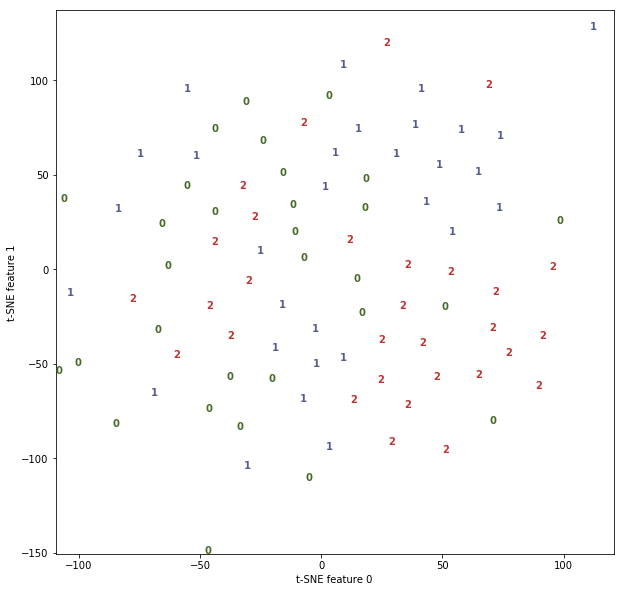

In [9]:
#T-SNE
tsne = TSNE(random_state=42)
d_tsne = tsne.fit_transform(X_train)
plt.figure(figsize=(10, 10))
plt.xlim(d_tsne[:, 0].min(), d_tsne[:, 0].max() + 10)
plt.ylim(d_tsne[:, 1].min(), d_tsne[:, 1].max() + 10)
for i in range(len(X_train)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(d_tsne[i, 0], d_tsne[i, 1], str(y_train[i]),
    color = colors[y_train[i]],
    fontdict={'weight': 'bold', 'size': 10})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

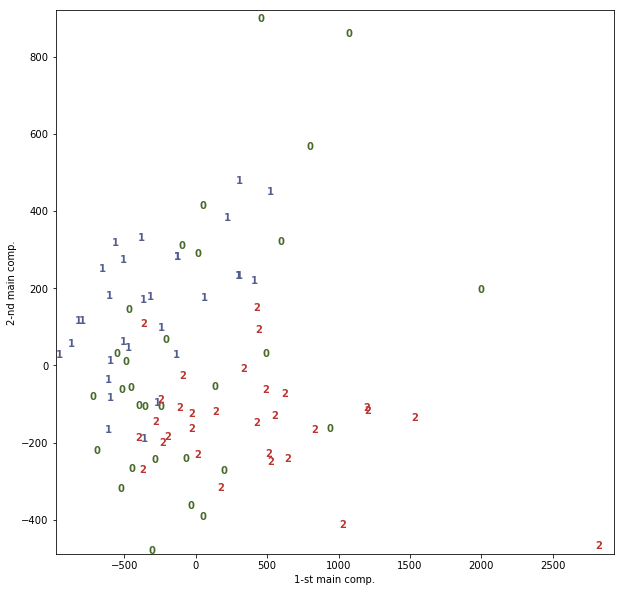

In [10]:
#PCA
pca = PCA(n_components=2, random_state=42)
pca.fit_transform(X_train)
d_pca =  pca.transform(X_train)
plt.figure(figsize=(10, 10))
plt.xlim(d_pca[:, 0].min(), d_pca[:, 0].max() + 130)
plt.ylim(d_pca[:, 1].min(), d_pca[:, 1].max() + 30)
for i in range(len(X_train)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(d_pca[i, 0], d_pca[i, 1], str(y_train[i]),
    color = colors[y_train[i]],
    fontdict={'weight': 'bold', 'size': 10})
plt.xlabel("1-st main comp.")
plt.ylabel("2-nd main comp.")

По двумерному представлению, разделить классы сложно  
  
On a two-dimensional view, it is difficult to divide classes

Давайте попробуем представить, что мы не знаем сколько всего классов в наших данных, в таком случае нам подойдет алгоритм DBSCAN, для наглядности будем обучать его на тестовой выборке.  
  
Let's try to imagine that we do not know how many classes in our data, in this case the DBSCAN algorithm will work for us. We will teach it on a test data.


In [11]:
#scale data
scaler = MinMaxScaler()
scaler.fit(X_test)
X_scaled = scaler.transform(X_test)

#clustering with DBSCAN
dbscan = DBSCAN(min_samples=2, eps=2.22, n_jobs=-1)
clusters = dbscan.fit_predict(X_scaled)
print("Affiliation to clusters:\n{}".format(clusters))
print("\n results (Clustering, real): \n",list(zip(clusters,y_test)))
print("\n accuracy_score: \n",accuracy_score(clusters,y_test))


Affiliation to clusters:
[-1 -1  0 -1 -1  0  0 -1  1  1 -1  2  2 -1 -1 -1 -1 -1  2 -1  2 -1 -1  1 -1
 -1  1  1  1 -1  1 -1  1]

 results (Clustering, real): 
 [(-1, 0), (-1, 0), (0, 0), (-1, 0), (-1, 0), (0, 0), (0, 0), (-1, 0), (1, 0), (1, 0), (-1, 0), (2, 1), (2, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (2, 1), (-1, 1), (2, 1), (-1, 1), (-1, 2), (1, 2), (-1, 2), (-1, 2), (1, 2), (1, 2), (1, 2), (-1, 2), (1, 2), (-1, 2), (1, 2)]

 accuracy_score: 
 0.0909090909091


Похоже, что скорее всего метки класса 1 и 2 в результатах кластеризации надо поменять местами.  
  
It seems that most likely labels of class 1 and 2 in the clustering results should be interchanged.


In [12]:
def swap_class(lst, number_one,number_two ):
    """
    The function is exchanging num1 and num2 in list and return new array
    """
    
    lst_new=[]
    for val in lst:
            if val == number_one:
                val = number_two
            elif val == number_two:
                val = number_one
            lst_new.append(val )
    return np.array(lst_new)

y_changed=swap_class(clusters, 1,2)
print("\n results (Clustering, real): \n",list(zip(y_changed,y_test)))
print("\n accuracy_score: \n",accuracy_score(y_changed,y_test))



 results (Clustering, real): 
 [(-1, 0), (-1, 0), (0, 0), (-1, 0), (-1, 0), (0, 0), (0, 0), (-1, 0), (2, 0), (2, 0), (-1, 0), (1, 1), (1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (1, 1), (-1, 1), (1, 1), (-1, 1), (-1, 2), (2, 2), (-1, 2), (-1, 2), (2, 2), (2, 2), (2, 2), (-1, 2), (2, 2), (-1, 2), (2, 2)]

 accuracy_score: 
 0.393939393939


Мы получили около 40% точно предсказанных классов, что хоть и плохо, но немного лучше, чем случайное назначение класса.   
  
We got about 40% of the classes predicted accurately that even though bad, but a little better than random assignment of class.
